In [1]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = "gpt-4o-mini", temperature = 0.2)

## define a Search Query

In [2]:
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized for web search")
    justification: str = Field(None, justification="Why this query is relevant to the user's request")

structured_llm = llm.with_structured_output(SearchQuery)

output = structured_llm.invoke("How does Calcium CT score related to high cholestrerol?")
print(output.search_query)
print(output.justification)

Calcium CT score and high cholesterol relationship
This query is relevant because it seeks to understand the connection between calcium scoring in coronary arteries and cholesterol levels, which is important for assessing cardiovascular risk.


## define tools

In [3]:
def multiply(a: int, b: int) -> int:
    return a * b

llm_with_tools = llm.bind_tools([multiply])
msg = llm_with_tools.invoke("multiply 2 and 3")
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_e5cMbWkB4SXuG0m1FrEMyIfb',
  'type': 'tool_call'}]

In [4]:
from typing_extensions import TypedDict

class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


def generate_joke(state: State) -> str:
    msg = llm.invoke(f"Write me a joke about {state['topic']}")
    return {"joke": msg.content}

def improve_joke(state: State) -> str:
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: State) -> str:
    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

def check_punchline(state: State) -> str:
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"

## define lang graph

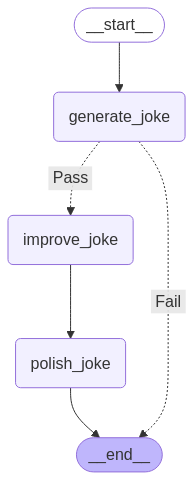

In [6]:
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image

workflow = StateGraph(State)
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges("generate_joke", check_punchline, {"Pass": "improve_joke", "Fail": END})
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

chain = workflow.compile()
display(Image(chain.get_graph().draw_mermaid_png()))

In [7]:
from pprint import pprint
from langfuse.callback import CallbackHandler
langfuse_handler = CallbackHandler()


state = chain.invoke({"topic": "cats"}, config={"callbacks": [langfuse_handler]})
pprint(state)

{'final_joke': 'Why was the cat sitting on the computer? \n'
               '\n'
               'Because it wanted to keep an eye on the mouse and make sure it '
               'didn’t click away! But little did it know, the mouse was '
               'actually a secret agent, and the cat was about to become the '
               'unwitting sidekick in a high-stakes cyber heist!',
 'improved_joke': 'Why was the cat sitting on the computer? \n'
                  '\n'
                  'Because it wanted to keep an eye on the mouse and make sure '
                  'it didn’t click away!',
 'joke': 'Why was the cat sitting on the computer?\n'
         '\n'
         'Because it wanted to keep an eye on the mouse!',
 'topic': 'cats'}
